In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 
import pickle 
import cortex
from dag_prf_utils.pycortex import *

import sys
import nibabel as nib
from nibabel.freesurfer.io import read_morph_data, write_morph_data
import cortex

no dash..


In [2]:
subj = 'sub-46'
subjectid='sub-46'
subject = subjectid
depth='GM'
project='PROJECT_EGRET-AAA'
space='fsnative'
roi=['all']
r2_thr=0.1
target_visual_area = 3
source_visual_area = 1
file_path = f'/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results/{subj}/V{target_visual_area}->V{source_visual_area}/best_fits.csv'  # Update with the actual path to your CSV file
MAIN_PATH = '/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives'
hemi = 'lh'
delineation = 'manualdelin'
labels_path = f"{MAIN_PATH}/freesurfer/{subj}/label/{hemi}.{delineation}.label"
data = pd.read_csv(file_path)
atlas = 'manual'
denoising = 'nordic'
task = 'RET'
fs_dir = f"{MAIN_PATH}/freesurfer"

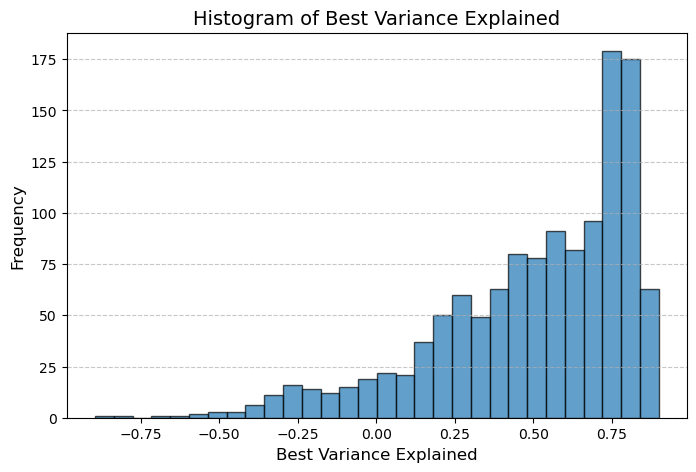

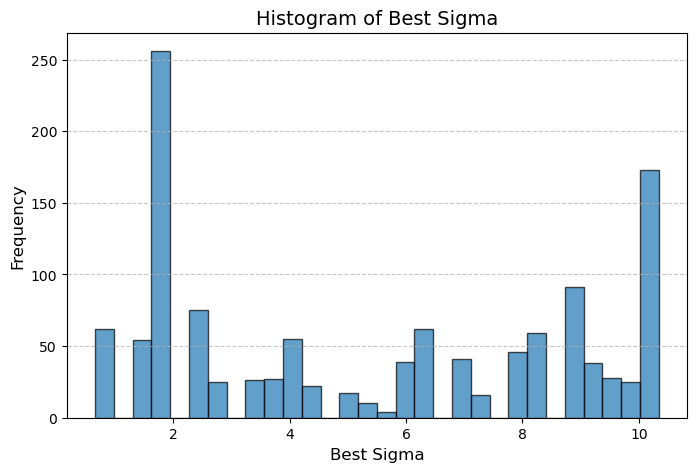

Number of unique values in 'Target Vertex Index': 1251


In [3]:
### VARIANCE EXPLAINED FREQUENCY 
plt.figure(figsize=(8, 5))
plt.hist(data['Best Variance Explained'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Histogram of Best Variance Explained', fontsize=14)
plt.xlabel('Best Variance Explained', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### SIGMA FREQUENCY 
plt.figure(figsize=(8, 5))
plt.hist(data['Best Sigma'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Histogram of Best Sigma', fontsize=14)
plt.xlabel('Best Sigma', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### TARGET INDICES
target_values = data['Target Vertex Index'].nunique()
print(f"Number of unique values in 'Target Vertex Index': {target_values}")

In [4]:
### EXTRACT ECCENTRICITY AND POLAR ANGLE 
class PRFModel:
    '''Class representing pRF model parameters '''
    def __init__(self, r2, size, ecc, angle):
        """
        Initialize the PRFModel instance with the following parameters:
            
        Parameters:
        r2 (float): Model fit value (R-squared). Represents how well the model explains the variance in the observed data. 
                    A higher value indicates a better fit.
        size (float): Size of the pRF (population receptive field), which describes the spatial extent or diameter of the receptive field.
        ecc (float): Eccentricity. Represents the distance of the pRF from the center of the visual field. Higher values mean the receptive field 
                    is located farther from the center (fovea).
        angle (float): Polar angle. Specifies the direction of the receptive field from the center, often in degrees or radians.
        """
        self.r2 = r2            # Model fit - represents how well the model explains data variance
        self.size = size        # Size of the pRF (population receptive field)
        self.ecc = ecc          # Eccentricity - distance of the pRF from the center
        self.angle = angle      # Polar angle - position angle of the pRF

def load_pickle_file(filepath):
    '''Function to load a pickle file given a file path'''
    # Check if the given file path points to an existing file
    if not os.path.isfile(filepath):
        # If the file does not exist, raise a FileNotFoundError
        raise FileNotFoundError(f"File not found: {filepath}")
    # Open the file in 'rb' mode (read binary) since pickle files contain serialized binary data
    with open(filepath, 'rb') as file: 
        # Deserializes the contents of the binary file and returns the Python object.
        return pickle.load(file)

def load_prf_params(subjectid, main_path, atlas, denoising, task):
    '''Function to load pRF parameters for a given subjects and other details'''
    # Construct the file path to the pRF parameters file based on input parameters
    # The path points to a pickle file that contains the pRF model information
    filepath = os.path.join(main_path, f'pRFM/{subjectid}/ses-02/{denoising}/model-{atlas}-nelder-mead-GM_desc-prf_params_{task}.pkl') 
    # Load the pickle file using the load_pickle_file function defined previously
    pkl_data = load_pickle_file(filepath)                       
    # Extract the pRF model parameters using the 'iterative_search_params' key from the loaded data
    prf_params = pkl_data['model'].iterative_search_params     
    # Extract the indices of the voxels that fall within the region of interest (ROI) 
    # This is done by finding where the 'rois_mask' is equal to 1 (indicating the voxel is inside the ROI)
    prf_voxels = np.where(pkl_data['rois_mask'] == 1)[0]      
    # Return both the extracted pRF model parameters and the indices of the voxels within the ROI
    return prf_params, prf_voxels

def filter_prf_data(prf_params, prf_voxels):
    '''Filter and extract pRF data for the selected voxels'''
    # Construct and return a PRFModel object containing specific parameters of interest
    # - r2, size, eccentricity, and polar angle for the selected voxels.
    return PRFModel(
        r2=prf_params[:, 7],                                                # Extract R2 values from column 7 of prf_params.
        size=prf_params[:, 2],                                              # Extract pRF size values from column 2 of prf_params.
        # Eccentricity is calculated as the Euclidean distance from the center (0,0)
        # This is done using the Pythagorean theorem: ecc = sqrt(x^2 + y^2).
        ecc=np.sqrt(prf_params[:, 1]**2 + prf_params[:, 0]**2),             # Calculate eccentricity 
        # np.arctan2(y, x) computes the angle (in radians) of the vector formed by (x, y) relative to the positive x-axis.
        # The function np.rad2deg() converts the resulting angle to degrees.
        angle=np.arctan2(prf_params[:, 1], prf_params[:, 0])    # Calculate polar angle
    )

def load_labels(subjectid, main_path, atlas):
    '''Function to load FreeSurfer labels for the specified subject'''
    # Define the path to the FreeSurfer directory within the main project directory
    fs_dir = os.path.join(main_path, 'freesurfer') 
    try:
        # Load label indices for visual areas and eccentricity regions:
        # Load visual area labels (V1, V2, V3, etc.) using Benson's visual area label ('benson14_varea-0001')
        idx_rois4, idx_vls4 = cortex.freesurfer.get_label(subjectid, label='benson14_varea-0001', fs_dir=fs_dir, hemisphere=('lh', 'rh'))
        # Load eccentricity labels using Benson's eccentricity label ('benson14_eccen-0001')
        idx_rois1, idx_vls1 = cortex.freesurfer.get_label(subjectid, label='benson14_eccen-0001', fs_dir=fs_dir, hemisphere=('lh', 'rh'))
        # Check if 'manual' atlas is specified
        # If a manual atlas is requested, load the manual labels and update the corresponding indices
        if atlas == 'manual': 
            idx_rois_manual, idx_vls_manual = cortex.freesurfer.get_label(subjectid, label='manualdelin', fs_dir=fs_dir, hemisphere=('lh', 'rh'))
            # Update the values in idx_vls4 to use the manual labels wherever applicable
            idx_vls4[idx_rois_manual] = idx_vls_manual
    except Exception as e:
        # If there is an error loading any of the labels, raise a RuntimeError
        raise RuntimeError(f"Error loading labels for subject {subjectid}: {e}")
    # Return the loaded indices and values:
    # - idx_rois4, idx_vls4: Visual area indices and labels
    # - idx_vls1: Eccentricity labels
    return idx_rois4, idx_vls4, idx_vls1

def extract_prf_properties(subj, main_path, atlas, denoising, task, csv_path):
    data = pd.read_csv(csv_path) # Load the best fits data
    prf_params, prf_voxels = load_prf_params(subj, main_path, atlas, denoising, task) # Load pRF parameters
    prf_data = filter_prf_data(prf_params, prf_voxels) # Filter the loaded pRF parameters

    # Create a mapping of voxel index to eccentricity and polar angle
    voxel_to_ecc = dict(zip(prf_voxels, prf_data.ecc)) # All the voxels: All the eccentricities
    voxel_to_angle = dict(zip(prf_voxels, prf_data.angle)) # All the voxels: All the polar angles

    # Extract the corresponding pRF properties
    data['Source Eccentricity'] = data['Source Vertex Index'].map(voxel_to_ecc) # 
    data['Source Polar Angle'] = data['Source Vertex Index'].map(voxel_to_angle)
    data['Target Eccentricity'] = data['Target Vertex Index'].map(voxel_to_ecc) # 
    data['Target Polar Angle'] = data['Target Vertex Index'].map(voxel_to_angle)

    # Save the new dataframe with extracted pRF properties
    output_csv_path = os.path.join(os.path.dirname(csv_path), 'best_fits_with_prf.csv')
    data.to_csv(output_csv_path, index=False)
    print(f"Updated file saved at: {output_csv_path}")
    return data

updated_data = extract_prf_properties(subj, MAIN_PATH, atlas, denoising, task, file_path)

updated_data

Updated file saved at: /Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results/sub-46/V3->V1/best_fits_with_prf.csv


,Target Vertex Index,Source Vertex Index,Best Sigma,Best Variance Explained,Source Eccentricity,Source Polar Angle,Target Eccentricity,Target Polar Angle
0,9399.0,3879.0,1.813098,0.156903,7.742444,-0.104758,7.922275,0.237444
1,10092.0,3879.0,1.813098,0.239770,7.742444,-0.104758,9.435875,0.616280
2,10101.0,3879.0,1.813098,0.384464,7.742444,-0.104758,10.588015,0.756519
3,9385.0,3879.0,1.813098,0.006401,7.742444,-0.104758,7.757862,0.122217
4,8725.0,3879.0,1.813098,-0.182138,7.742444,-0.104758,5.425918,-0.120510
...,...,...,...,...,...,...,...,...
1246,4900.0,104103.0,9.253895,-0.403947,6.978306,0.979862,6.769596,-0.455264
1247,4899.0,2407.0,1.900023,-0.293345,5.423192,-0.585481,6.720749,-0.460094
1248,4887.0,104103.0,9.253895,-0.468979,6.978306,0.979862,6.763230,-0.456926
1249,2092.0,641.0,6.335633,0.768369,0.399029,-1.804328,0.500209,-1.245215


In [5]:
# PLOT THE SIGMA AND THE VARIANCE EXPLAINED ON THE SURFACE 
best_fits_path = f'/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results/{subj}/V{target_visual_area}->V{source_visual_area}/best_fits_with_prf.csv'
best_fits_data = pd.read_csv(file_path)

prf_params_vx = best_fits_data['Target Vertex Index'].values.astype(int)
r2 = best_fits_data['Best Variance Explained'].values
size = best_fits_data['Best Sigma'].values
# Initialize the cortex.Vertex object for visualization
angle_map = cortex.Vertex.empty(f'{subj}')

# Initialize masked data arrays
masked_r2 = np.zeros(angle_map.nverts)
masked_radius = np.zeros(angle_map.nverts)

# Apply the filtering mask
r2_mask = r2 > 0.01
total_mask = r2_mask 
r2[total_mask == False] = 0
size[total_mask == False] = 0

# Assign filtered values to the cortical map
masked_r2[prf_params_vx] = r2
masked_radius[prf_params_vx] = size

# Create necessary files for visualization
fs_dir = f'{MAIN_PATH}/freesurfer/{subj}/surf'
lh_c = read_morph_data(f'{fs_dir}/lh.curv')
lh_masked_r2 = masked_r2[:lh_c.shape[0]]
rh_masked_r2 = masked_r2[lh_c.shape[0]:]
lh_masked_radius = masked_radius[:lh_c.shape[0]]
rh_masked_radius = masked_radius[lh_c.shape[0]:]

write_morph_data(f'{fs_dir}/lh.cf_r2_{delineation}_{task}', lh_masked_r2)
write_morph_data(f'{fs_dir}/rh.cf_r2_{delineation}_{task}', rh_masked_r2)
write_morph_data(f'{fs_dir}/lh.cf_radius_{delineation}_{task}', lh_masked_radius)
write_morph_data(f'{fs_dir}/rh.cf_radius_{delineation}_{task}', rh_masked_radius)

In [6]:
"""# Extract parameters from best_fits.csv
prf_params_vx = best_fits_data['Target Vertex Index'].values.astype(int)
print(f"The total amount of vertices in the target: {prf_params_vx.shape[0]}")
eccentricity = best_fits_data['Source Eccentricity'].values
print(f"The value of eccentricity of the best fit in the source: {eccentricity[1]}")
polar_angle = best_fits_data['Source Polar Angle'].values
print(f"The value of polar angle of the best fit in the source: {polar_angle[1]}")

angle_map = cortex.Vertex.empty(subjectid)
masked_polar_angle=np.zeros(angle_map.nverts)
masked_polar_angle[:]=50
masked_eccentricity=np.zeros(angle_map.nverts)
masked_eccentricity[:]=50

r2_mask = r2 > 0.01 # creates Boolean array with those vertices above the threshold
ecc_mask = eccentricity < 8
total_mask = r2_mask * ecc_mask # Boolean array where both above r squared and below maximum eccentricity
polar_angle[total_mask==False]=50
eccentricity[total_mask==False]=50
masked_polar_angle[prf_params_vx]=polar_angle
masked_eccentricity[prf_params_vx]=eccentricity

fs_dir=f'{MAIN_PATH}/freesurfer/{subjectid}/surf/'
lh_c = read_morph_data(f'{fs_dir}/lh.curv')
lh_masked_pol = masked_polar_angle[:lh_c.shape[0]] # left hemisphere = all vertices up to the index
rh_masked_pol = masked_polar_angle[lh_c.shape[0]:] # all vertices from that vertex onwards belong to the right hemisphere
lh_masked_ecc = masked_eccentricity[:lh_c.shape[0]] # left hemisphere = all vertices up to the index
rh_masked_ecc = masked_eccentricity[lh_c.shape[0]:] # all vertices from that vertex onwards belong to the right hemisphere

write_morph_data(f'{fs_dir}/lh.cf_pol_{delineation}_{task}', lh_masked_pol)
write_morph_data(f'{fs_dir}/rh.cf_pol_{delineation}_{task}', rh_masked_pol)
write_morph_data(f'{fs_dir}/lh.cf_ecc_{delineation}_{task}', lh_masked_ecc)
write_morph_data(f'{fs_dir}/rh.cf_ecc_{delineation}_{task}', rh_masked_ecc)"""

'# Extract parameters from best_fits.csv\nprf_params_vx = best_fits_data[\'Target Vertex Index\'].values.astype(int)\nprint(f"The total amount of vertices in the target: {prf_params_vx.shape[0]}")\neccentricity = best_fits_data[\'Source Eccentricity\'].values\nprint(f"The value of eccentricity of the best fit in the source: {eccentricity[1]}")\npolar_angle = best_fits_data[\'Source Polar Angle\'].values\nprint(f"The value of polar angle of the best fit in the source: {polar_angle[1]}")\n\nangle_map = cortex.Vertex.empty(subjectid)\nmasked_polar_angle=np.zeros(angle_map.nverts)\nmasked_polar_angle[:]=50\nmasked_eccentricity=np.zeros(angle_map.nverts)\nmasked_eccentricity[:]=50\n\nr2_mask = r2 > 0.01 # creates Boolean array with those vertices above the threshold\necc_mask = eccentricity < 8\ntotal_mask = r2_mask * ecc_mask # Boolean array where both above r squared and below maximum eccentricity\npolar_angle[total_mask==False]=50\neccentricity[total_mask==False]=50\nmasked_polar_angle[p

In [7]:
# EXTRACT THE GAUSSIAN WEIGHTS
best_fits_path = f'/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results_ONE/{subj}/V{target_visual_area}->V{source_visual_area}/best_fits.csv'
best_fits_data = pd.read_csv(best_fits_path)


best_fits_data["Gaussian Weights"] = best_fits_data["Gaussian Weights"].apply(eval) # Convert the "Gaussian Weights" column from string to dictionary
source_vertex_and_weights = [] # Extract source vertex indices and their Gaussian weights 
for _, row in best_fits_data.iterrows():
    weight_dict = row["Gaussian Weights"]
    for source_vertex, weight in weight_dict.items():
        source_vertex_and_weights.append([source_vertex, weight])  # Store as [source_vertex, weight]

weights_df = pd.DataFrame(source_vertex_and_weights, columns=["Source Vertex Index", "Gaussian Weight"]) # Panda dataframe
output_file_path = f'/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results/{subj}/V{target_visual_area}->V{source_visual_area}/source_vertex_and_weights.csv'
weights_df.to_csv(output_file_path, index=False)

In [ ]:
file_path_sigma = f"/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results_ONE/sub-46/V3->V1/individual_fits/all_fits_target_vertex_9399.csv"
best_fits_sigma = pd.read_csv(file_path_sigma)
best_fit_output = f"/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results_ONE/sub-46/V3->V1/individual_fits/bestfit_sigma.csv"


maxVE = best_fits_sigma["Best Variance Explained"].max()
print(maxVE)
best_fit = best_fits_sigma[best_fits_sigma["Best Variance Explained"] == maxVE]
        # best_fit_df = pd.DataFrame([best_fit])
        # best_fit_df.to_csv(best_fit_output, mode="a", index=False, header=not os.path.exists(best_fit_output))
# best_fit_df = best_fit.copy()
# best_fit_df.to_csv(f"/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results_ONE/sub-46/V3->V1/individual_fits/bestfit_sigma.csv", mode="a", index=False, header=not os.path.exists(best_fit_output))

best_fit_source = best_fits_sigma[best_fits_sigma["Source Vertex Index"] == 2559]
        # best_fit_df = pd.DataFrame([best_fit])
        # best_fit_df.to_csv(best_fit_output, mode="a", index=False, header=not os.path.exists(best_fit_output))
best_fit_source = best_fit_source.copy()
best_fit_source.to_csv(f"/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results_ONE/sub-46/V3->V1/individual_fits/bestfit_sigma.csv", mode="a", index=False, header=not os.path.exists(best_fit_output))

0.1070048033977443


'\nmaxVE = best_fits_sigma["Best Variance Explained"].max()\nprint(maxVE)\n#maxVE = -1.1184336683485907\nbest_fit = best_fits_sigma[best_fits_sigma["Best Variance Explained"] == maxVE]\n# best_fit = best_fits_sigma[best_fits_sigma["Source Vertex Index"] == 1751]\n# best_fit = results_df[results_df["Best Variance Explained"] == maxVE]\nprint(best_fit)\n# first_row = best_fit.iloc[0]\n# print(first_row)\n\n# best_fit_df = first_row.copy()\nbest_fit_df = best_fit.copy()\nbest_fit_output = f"/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results_ONE/sub-46/V3->V1/individual_fits/bestfit_sigma.csv"\nbest_fit_df.to_csv(best_fit_output, mode="a", index=False, header=not os.path.exists(best_fit_output))\n\n\n        \n        # best_fit_df = pd.DataFrame([best_fit])\n        # best_fit_df.to_csv(best_fit_output, mode="a", index=False, header=not os.path.exists(best_fit_output))\n        #best_fit_df = best_fit.copy()\n        #best_fit_df.to_csv(best_fit_output, mode="a", ind

In [27]:
# EXTRACT THE GAUSSIAN WEIGHTS
best_fits_path = f'/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results_ONE/{subj}/V{target_visual_area}->V{source_visual_area}/individual_fits/bestfit_sigma.csv'
best_fits_sigma = pd.read_csv(best_fits_path)
#best_fits_sigma["Gaussian Weights"] = best_fits_sigma["Gaussian Weights"].values # Convert the "Gaussian Weights" column from string to dictionary
best_fits_sigma["Gaussian Weights"] = best_fits_sigma["Gaussian Weights"].apply(eval)  # Convert to dictionary
source_vertex_and_weights = [] # Extract source vertex indices and their Gaussian weights 
for _, row in best_fits_sigma.iterrows():
    weight_dict = row["Gaussian Weights"]
    for source_vertex, weight in weight_dict.items():
        source_vertex_and_weights.append([source_vertex, weight])  # Store as [source_vertex, weight]

weights_df = pd.DataFrame(source_vertex_and_weights, columns=["Source Vertex Index", "Gaussian Weight"]) # Panda dataframe
output_file_path = f'/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results/{subj}/V{target_visual_area}->V{source_visual_area}/source_vertex_and_weights_sigma.csv'
weights_df.to_csv(output_file_path, index=False)

In [28]:
# PLOT THE GAUSSIAN WEIGHTS
weights_data = pd.read_csv(f'/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/results/{subj}/V{target_visual_area}->V{source_visual_area}/source_vertex_and_weights_sigma.csv')
weights = weights_data['Gaussian Weight'].values  # Convert Gaussian weights from string to dictionary

prf_params_vx = weights_data['Source Vertex Index'].values.astype(int) ## (1688,)

angle_map = cortex.Vertex.empty(f'{subj}')
masked_weights = np.zeros(angle_map.nverts) # 248511
masked_weights[:]=50
masked_weights[prf_params_vx]=weights
print(masked_weights.shape)

rh_masked_weights = masked_weights[lh_c.shape[0]:]
lh_masked_weights = masked_weights[:lh_c.shape[0]]

write_morph_data(f'{fs_dir}/lh.cf_weights_bestsigma', lh_masked_weights)
write_morph_data(f'{fs_dir}/rh.cf_weights_bestsigma', rh_masked_weights)

(248511,)


In [23]:
distance_matrix_path = "/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/sub-46_distance_lh_1.csv"
distance_matrix = pd.read_csv(distance_matrix_path, header=None, index_col=None)

# Extract the first row and first column to find the correct index of the vertex 2559
vertex_indices = distance_matrix.iloc[0,1:].values  # The first row (excluding the NaN at [0,0])
row_index = np.where(vertex_indices == 2559)[0]  
print(f"The column values: {vertex_indices}")
print(f"The column index where 2559 appears: {row_index[0]}")

column_indices = distance_matrix.iloc[1:, 0].values  # The first column (excluding NaN at [0,0])
col_index = np.where(column_indices == 2559)[0]  # Find the row index where 2559 appears
print(f"The first column values: {column_indices}")
print(f"The column index where 2559 appears: {col_index[0]}")

# Adjust because we ignored the first row for indexing
row_index = row_index[0] + 1  
col_index = col_index[0] + 1  

distance_from_row = distance_matrix.iloc[row_index, 1:].values
print("Distances from row:", distance_from_row[:5])
distance_from_column = distance_matrix.iloc[1:, col_index].values  
print("Distances from column:", distance_from_column[:5])

# Create DataFrames for saving
row_df = pd.DataFrame({"Source Vertex Index": vertex_indices, "Distance Row": distance_from_row})
column_df = pd.DataFrame({"Source Vertex Index": column_indices, "Distance Column": distance_from_column})
row_csv_path = "/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/sub-46_distance_row.csv"
column_csv_path = "/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/sub-46_distance_column.csv"
row_df.to_csv(row_csv_path, index=False)
column_df.to_csv(column_csv_path, index=False)

# PLOT THE GAUSSIAN WEIGHTS
distance_row_data = pd.read_csv(f'/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/sub-46_distance_row.csv')
distance_column_data = pd.read_csv(f'/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF/sub-46_distance_column.csv')

distance_row = distance_row_data['Distance Row'].values
distance_column = distance_column_data['Distance Column'].values

prf_params_vx = distance_row_data['Source Vertex Index'].values.astype(int) ## (1688,)
angle_map = cortex.Vertex.empty(f'{subj}')

masked_distance_row = np.zeros(angle_map.nverts) # 248511
masked_distance_row[:]=50
masked_distance_row[prf_params_vx]=distance_row

masked_distance_column = np.zeros(angle_map.nverts) # 248511
masked_distance_column[:]=50
masked_distance_column[prf_params_vx]=distance_column


rh_masked_distance_column = masked_distance_column[lh_c.shape[0]:]
lh_masked_distance_column = masked_distance_column[:lh_c.shape[0]]

rh_masked_distance_row = masked_distance_row[lh_c.shape[0]:]
lh_masked_distance_row = masked_distance_row[:lh_c.shape[0]]

write_morph_data(f'{fs_dir}/lh.cf_distance_column', lh_masked_distance_column)
write_morph_data(f'{fs_dir}/lh.cf_distance_row', lh_masked_distance_row)

# write_morph_data(f'{fs_dir}/rh.cf_weights_bestsigma', rh_masked_weights)


The column values: [  2931.   3360. 124438. ... 104103.  11370.   9929.]
The column index where 2559 appears: 552
The first column values: [  2931.   3360. 124438. ... 104103.  11370.   9929.]
The column index where 2559 appears: 552
Distances from row: [10.263288 11.09295  10.892195  9.893319 10.684354]
Distances from column: [10.076168  10.893798  10.652389   9.683541  10.4915285]


In [ ]:
## MARCUS 
updated_data
v1_ecc = np.zeros(pm.total_n_vx)
v1_ecc[updated_data['Source Vertex Index'].astype(int)] = updated_data['Eccentricity']
v1_ecc

NameError: name 'pm' is not defined

In [ ]:
## MARCUS 
pm = PyctxMaker(
    sub=subj,
    fs_dir=fs_dir)

Using fs dir = /Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer
/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/pycortex
default
/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/pycortex/sub-34


flat
{'cmap': 'viridis', 'vmin': 0.5322311254520338, 'vmax': 10.82397677864228}


{'cmap': 'viridis', 'vmin': 0.5322311254520338, 'vmax': 10.82397677864228}

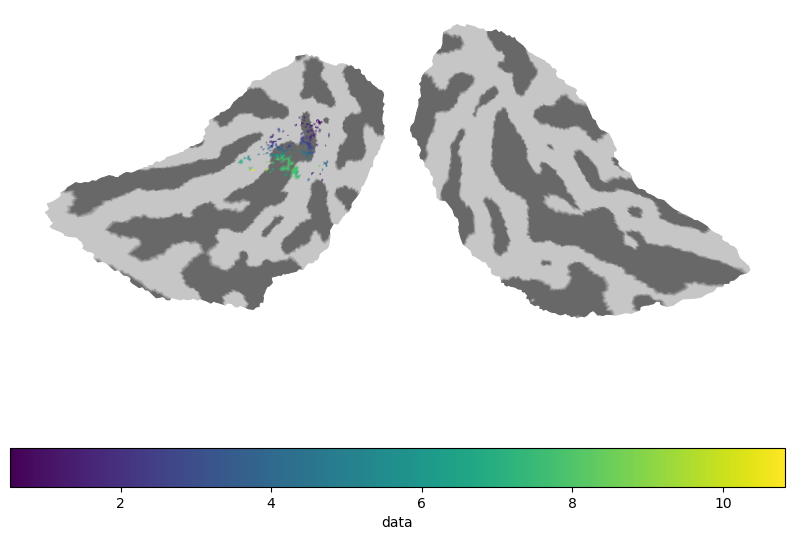

In [ ]:
## MARCUS 
pm.flat_mpl(data=v1_ecc, data_mask=v1_ecc!=0)